In [231]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
warnings.filterwarnings('ignore')

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def build_df(file_id, file_name):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(file_name)
  return pd.read_csv(file_name)

df = build_df('1LEbg13-KBZzHmIWAv9SnthGUzjvcbJuA','stylo-data.csv')
news_df = build_df('15zZXsks6cI0FY4vpL555lBQSBr1QyjT4', 'news-data.csv' )
varela_df = build_df('1JoC7GlAmdQO9WPZeJZKMbv4djyQzeezC',  'varela-stylo-data.csv')
varela_df.pop('Subject')

0       ASSUNTOS VARIADOS
1       ASSUNTOS VARIADOS
2       ASSUNTOS VARIADOS
3       ASSUNTOS VARIADOS
4       ASSUNTOS VARIADOS
              ...        
2995              TURISMO
2996              TURISMO
2997              TURISMO
2998              TURISMO
2999              TURISMO
Name: Subject, Length: 3000, dtype: object

In [232]:
#Some clean-up on line breaks
def clean_df(df):
  df = df.replace(to_replace ='\r', value = ' ', regex = True) 
  df = df.replace(to_replace ='\n ', value = '\n', regex = True) 
  df = df.replace(to_replace ='\n', value = ' ', regex = True)
  df = df.replace(to_replace ='\n{2,*}', value = ' ', regex = True)
  return df

#Read textual datasets
raw_df_test = build_df('1B-Ozck3R_cMeREw3yQQcODcz8UZ8Hvp7', 'raw_data.csv')
raw_df = clean_df(build_df('1B-Ozck3R_cMeREw3yQQcODcz8UZ8Hvp7', 'raw_data.csv'))
raw_news_df = clean_df(build_df('1P0UF5IRI3VNUuAulldEn84ntVfFLGiIq', 'raw_news_data.csv'))
raw_varela_df = clean_df(build_df('1s-qn2puLikOtN1YGOX2WZfZrNMxA6K4e', 'raw_varela_data.csv'))

raw_news_df.pop('Link')
raw_varela_df.pop('Subject')



def remove_varela_authors(df):
  regex_baleia = 'baleia - \d{1,2}\/\d{1,2}\/\d{2,4}'
  regex_ana = 'ana cristina cavalcante\s*\d{1,2} \w{1,4} \d{2,4} - \S{3,5}(min)*'
  regex_adriano = 'adriano gambarini - \d{1,2}\/\d{1,2}\/\d{2,4}'
  regex_ivolnildo = 'ivon(i)*l(d)*o lavôr(\s)*\d{1,2} \w{1,4} \d{2,4} - \S{4,5}(min)*'
  regex_mario = 'mário pinto(\s)*\d{1,2} \w{1,4} \d{2,4} - \S{4,5}(min)*'
  regex_julio = "mais sobr julio preuss - \d{1,2}\/\d{1,2}\/\d{2,4}(julio preussescreveu o livro 'fotografia digital: da compra da câmera à impressão das fotos)*"
  regex_roberto = 'roberto linsker - \d{1,2}\/\d{1,2}\/\d{2,4}'
  df['Text'] = df['Text'].str.replace(regex_baleia, ' ')
  df['Text'] = df['Text'].str.replace(regex_ana, ' ')
  df['Text'] = df['Text'].str.replace(regex_adriano, ' ')
  df['Text'] = df['Text'].str.replace(regex_ivolnildo, ' ')
  df['Text'] = df['Text'].str.replace(regex_mario, ' ')
  df['Text'] = df['Text'].str.replace(regex_julio, ' ')
  df['Text'] = df['Text'].str.replace(regex_roberto, ' ')
  return df

raw_varela_df = remove_varela_authors(raw_varela_df)


In [7]:
from __future__ import print_function
import time
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

!pip install scikit-fuzzy
import skfuzzy as fuzz
from sklearn.cluster import MiniBatchKMeans

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, Normalizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.cluster import KMeansClusterer
from sklearn import cluster, metrics
nltk.download('punkt')
nltk.download('stopwords')

from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import roc_auc_score
from scipy import interp
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import math

from matplotlib.colors import ListedColormap
from matplotlib.cm import hsv


from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [233]:
# Remove few class entries (We need at least 3 samples of an author) and encode Author column 

def remove_entries(df, size):
  return df.groupby('Author').filter(lambda x: len(x) > size)

def encode_target_column(df, column):
  le = LabelEncoder()
  y = df.pop(column)
  encoded_Y = le.fit_transform(y)
  return encoded_Y

df = remove_entries(df, 2)
raw_df = remove_entries(raw_df, 2)

encoded_Y = encode_target_column(df, 'Author')
encoded_raw_Y  = encode_target_column(raw_df, 'Author')

encoded_Y_news  = encode_target_column(news_df, 'Author')
raw_news_df.pop('Author')

varela_Y_backup = varela_df['Author']
encoded_varela_Y = encode_target_column(varela_df, 'Author')
raw_varela_df.pop('Author')

0       FOIRA
1       FOIRA
2       FOIRA
3       FOIRA
4       FOIRA
        ...  
2995    RBEIA
2996    RBEIA
2997    RBEIA
2998    RBEIA
2999    RBEIA
Name: Author, Length: 3000, dtype: object

In [ ]:
#Visualize tokens by author

view_df = raw_df.copy()
view_df['Text'] = view_df['Text'].str.split(' ').apply(len)

view_df = view_df.groupby('Author').agg(['sum', 'count'])


ax = raw_df['Author'].value_counts().plot.bar()
fig = plt.gcf()
fig.set_size_inches(15, 12)

In [ ]:
#varela_df.drop('Subject', axis=1, inplace=True)
print(news_df.shape)
clf = ExtraTreesClassifier(n_estimators=150)
clf = clf.fit(news_df, encoded_Y_news)
model = SelectFromModel(clf, prefit=True)
new_X = model.transform(news_df)

In [9]:
# Verification evaluation functions

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

  #creating a set of all the unique classes using the actual class list
  unique_class = set(actual_class)
  roc_auc_dict = {}
  for per_class in unique_class:
    #creating a list of all the classes except the current class 
    other_class = [x for x in unique_class if x != per_class]

    #marking the current class as 1 and all other classes as 0
    new_actual_class = [0 if x in other_class else 1 for x in actual_class]
    new_pred_class = [0 if x in other_class else 1 for x in pred_class]

    #using the sklearn metrics method to calculate the roc_auc_score
    roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
    roc_auc_dict[per_class] = roc_auc

  return roc_auc_dict


def classification_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df



In [ ]:

X_varela, X_varela_test, Y_varela, Y_varela_test = train_test_split(varela_df, encoded_varela_Y, random_state=7, test_size=0.3, stratify=encoded_varela_Y)

X_news, X_news_test, Y_news, Y_news_test = train_test_split(news_df, encoded_Y_news, random_state=7, test_size=0.3, stratify=encoded_Y_news)

X_student, X_student_test, Y_student, Y_student_test = train_test_split(df, encoded_Y, random_state=7, test_size=0.3, stratify=encoded_Y)

news_df['Author'] = encoded_Y_news

varela_df['Author'] = encoded_varela_Y

df['Author'] = encoded_Y


In [ ]:
# Atribution evaluation functions

def binarize(df, author_value):
  copy_df = df.copy()
  copy_df['Author'] = copy_df['Author'].apply(lambda x: int(x == author_value))
  return copy_df

def calculate_rates(y_test, y_pred, verbose=False):
  tp, fp, fn, tn = metrics.confusion_matrix(y_test, y_pred).ravel()
  accuracy = metrics.accuracy_score(y_pred = y_pred, y_true = y_test)
  precision = metrics.precision_score(y_pred = y_pred, y_true = y_test)
  recall = metrics.recall_score(y_pred = y_pred, y_true = y_test)
  f1_score = 2 * precision * recall/(precision + recall)
  auc_roc = roc_auc_score(y_score = y_pred, y_true = y_test)
  if(verbose):
    print('acc, prec, recall, f1', accuracy, precision, recall, f1_score)
  return accuracy, precision, recall, f1_score, auc_roc

def authorship_verification(df, target_column):
  dfs = dict()
  results = dict()

  aucs = []
  accs = []
  f1s = []
  precisions = []
  recalls = []
  authors = set()
  for author in set(df[target_column]):
    authors.add(author)
    copy_df = df.copy()
    copy_df = binarize(copy_df, author)
    dfs[author] = copy_df
    
    Y = copy_df.pop(target_column)
    X, X_test, Y, Y_test = train_test_split(copy_df, Y, random_state=7, test_size=0.3, stratify=Y)
    clf = RandomForestClassifier(random_state=0, n_estimators=500).fit(X, Y)
    Y_pred_proba = clf.predict_proba(X_test)
    Y_pred = clf.predict(X_test)
    

    acc_, prec_, recall_, f1_, auc_ = calculate_rates(Y_test, Y_pred)

    precisions.append(prec_)
    recalls.append(recall_)
    f1s.append(f1_)  
    accs.append(acc_) 
    aucs.append(auc_)
    
    #TODO: Validar com cleber
    #roc_auc_score = metrics.roc_auc_score(Y_test,Y_pred_proba[:,1])
    #aucs.append(roc_auc_score)

  frame = {'acc': pd.Series(accs), 'AUC ROC': pd.Series(aucs), 
           'precisão': pd.Series(precisions), 'recall': pd.Series(recalls),
           'f1': pd.Series(f1s)}

  result_df = pd.DataFrame(frame, index=authors)
  result_df.fillna(0, inplace=True)
  result_df.loc['média'] = result_df['acc'].mean(), result_df['AUC ROC'].mean(), result_df['precisão'].mean(), result_df['recall'].mean(), result_df['f1'].mean()
  return result_df

# This needs Author column in the df  
#authorship_verification(news_df, 'Author')


In [ ]:
#authorship_verification(varela_df, 'Author')

In [ ]:
#authorship_verification(df, 'Author')

In [ ]:
# Display metrics

def train_and_report(X, X_test, Y, Y_test, dataset_name, average='macro'):

  clf = RandomForestClassifier(random_state=0, n_estimators=500).fit(X, Y)
  y_pred = clf.predict(X_test)
  report_with_auc = classification_report(
      y_true=Y_test, 
      y_pred=y_pred, 
      y_score=clf.predict_proba(X_test),
      average=average)
  
  print(dataset_name)
  print(report_with_auc)
  print('ACCURACY:', accuracy_score(Y_test, y_pred))

  roc_auc_dict = roc_auc_score_multiclass(Y_test, y_pred, average=average)
  print('ROC AUC MEAN:', np.mean(list(roc_auc_dict.values())))
  return report_with_auc, y_pred


train_and_report(X_varela, X_varela_test, Y_varela, Y_varela_test, 'Base Varela', average="macro")
report, y_pred = train_and_report(X_news, X_news_test, Y_news, Y_news_test, 'Base de notícias', average="macro")
train_and_report(X_student, X_student_test, Y_student, Y_student_test, 'Base de estudantes', average="macro")

In [ ]:
varela_df['Author'].value_counts()

In [ ]:



#SelectFromModel will select those features which importance is greater than the mean importance of all the features by default
# print(varela_df.shape)
# clf = ExtraTreesClassifier(n_estimators=150)
# clf = clf.fit(varela_df, encoded_varela_Y)
# model = SelectFromModel(clf, prefit=True)
# X_new = model.transform(varela_df)
             
# print(X_new.shape)
# X_2, X_2_test, Y_2, y_2_test = train_test_split(news_df, encoded_Y_news, random_state=7, test_size=0.3, stratify=encoded_Y_news)

clf1 = RandomForestClassifier(random_state=0, n_estimators=250).fit(X, Y)
#clf2 = RandomForestClassifier(random_state=0, n_estimators=250).fit(X_2, Y_2)
#clf1 = OneVsRestClassifier(RandomForestClassifier(random_state=0, n_estimators=250)).fit(X, Y)

y_pred = clf1.predict(X_test)
y_pred_prob = clf1.predict_proba(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

#print(cnf_matrix)

print('Test ACC:', accuracy_score(y_test, y_pred))
roc_auc_score_multiclass(y_test, y_pred)


#y_pred_2 = clf2.predict(X_2_test)
#fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test, y_pred_prob, pos_label=2)
#fpr_2, tpr_2, thresholds = metrics.roc_curve(y_2_test, y_pred_2, pos_label=2)

#y_pred_val = clf1.predict(X_val)
#y_pred_2 = clf2.predict(X_2_test)

#fpr_val, tpr_val, thresholds = metrics.roc_curve(y_val, y_pred_val, pos_label=2)



#metrics.roc_auc_score(y_test, y_pred_prob, multi_class='ovo')

#print('Test AUC:', metrics.auc(fpr, tpr))

#print('Val ACC:', accuracy_score(y_test, y_pred_val))
#print('Val AUC:', metrics.auc(fpr_val, tpr_val))

#print('ACC:', accuracy_score(y_2_test, y_pred_2))
#print('AUC:', metrics.auc(fpr_2, tpr_2))

# y_pred_1 = clf1.predict(X_test)



In [11]:
tagged_documents = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(raw_df['Text'])]

#print (tagged_documents)

model = Doc2Vec(tagged_documents, vector_size=30, min_count=1, workers=4)

documents = [doc.words for doc in tagged_documents]
#print(documents)

In [13]:
# Create a wordcloud for each one of the authors

stopwords = set(nltk.corpus.stopwords.words('portuguese'))

def get_words(text):
  words = ' '.join(text)
  tokens = nltk.word_tokenize(words, language = 'portuguese')
  embedded_tokens = [token for token in tokens]
  #embedded_tokens = [token for token in tokens if token.lower() in word_embedding_dict.keys()]
  return " ".join(embedded_tokens)

def build_wordcloud(words, stopwords):
  return WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=500,
                      height=500
                     ).generate(get_words(words))

# wcs = []
# for i in range(0,11):
#   wcs.append(build_wordcloud(raw_df.loc[raw_df['Author'] == i]['Text'], stopwords))

In [ ]:
# Display Wordclouds
fig = plt.figure()
fig.set_figheight(100)
for idx, i  in enumerate(wcs):
    ax = fig.add_subplot(len(wcs),1,idx+1)
    wordcloud = i
    ax.imshow(wordcloud)
    ax.axis('off')

In [ ]:
raw_df['size'] = raw_df['Text'].str.split(' ').apply(len)
max(raw_df['size'])

#25876 tokens divididos entre 84 trabalhos = 

In [ ]:
# Amount of works and valid tokens 

authors = {}
for i in range(0,16):
  author_texts = raw_df.loc[raw_df['Author'] == i]['Text']
  words = get_words(author_texts)
  tokens = nltk.word_tokenize(words, language = 'portuguese')
  #tokens = [w for w in tokens if w.lower() not in stopwords]
  authors[le.inverse_transform([i])[0]] = (len(author_texts), len(tokens)) 

authors



In [ ]:
#Plot author works and the number of valid tokens

#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))

word_count = [size[1] for size in authors.values()]
X = authors.keys()
works_count =  [size[0] for size in authors.values()]
axes[0].bar(X,works_count)

plt.ylabel('Total de tokens (palavras)')
plt.xlabel('Autores')
plt.bar(X, word_count)


#axes[1].bar(X,word_count)
figure = plt.gcf()
figure.set_size_inches(15, 12)


In [ ]:
#TODO : Verificar o tamanho correto dos datasets e adicionar no texto
#TODO: Existem várias palavras com \n, talvez o metodo de limpeza esteja bugado
print(len(((''.join(raw_df['Text']).split(' ')))))
print(len(set((''.join(raw_df['Text']).split(' ')))))


print(len(((''.join(raw_news_df['Text']).split(' ')))))
print(len(set((''.join(raw_news_df['Text']).split(' ')))))

print(len(((''.join(raw_varela_df['Text']).split(' ')))))
print(len(set((''.join(raw_varela_df['Text']).split(' ')))))

# vocab sizes atm: 

# students = 8390
# news = 16081
# varela = 147131

In [ ]:
# Scale our stylometric datasets

scaled_features_news = PowerTransformer().fit_transform(news_df.values)
news_df = pd.DataFrame(scaled_features_news, index=news_df.index, columns=news_df.columns)

scaled_features = PowerTransformer().fit_transform(df.values)
df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

In [147]:
# Plotting helper functions

def set_title_and_labels(ax, reduction_name, dataset_name, label_name='', is_3d=False, stylo=True):
  if stylo:
    ax.set_title('Features estilométricas ' + '({})'.format(reduction_name) + ' - ' + dataset_name)
  else:
    ax.set_title('Representação textual' + '({})'.format(reduction_name) + ' - ' + dataset_name)
  ax.set_xlabel(label_name)
  ax.set_ylabel(label_name)
  if is_3d:
    ax.set_zlabel(label_name)

# Custom colormap function
def generate_colormap(number_of_distinct_colors: int = 80):
    if number_of_distinct_colors == 0:
        number_of_distinct_colors = 80

    number_of_shades = 7
    number_of_distinct_colors_with_multiply_of_shades = int(math.ceil(number_of_distinct_colors / number_of_shades) * number_of_shades)
    linearly_distributed_nums = np.arange(number_of_distinct_colors_with_multiply_of_shades) / number_of_distinct_colors_with_multiply_of_shades
    arr_by_shade_rows = linearly_distributed_nums.reshape(number_of_shades, number_of_distinct_colors_with_multiply_of_shades // number_of_shades)

    # Transpose the above matrix (columns become rows) - as a result each row contains saw tooth with values slightly higher than row above
    arr_by_shade_columns = arr_by_shade_rows.T

    # Keep number of saw teeth for later
    number_of_partitions = arr_by_shade_columns.shape[0]
    nums_distributed_like_rising_saw = arr_by_shade_columns.reshape(-1)
    initial_cm = hsv(nums_distributed_like_rising_saw)

    lower_partitions_half = number_of_partitions // 2
    upper_partitions_half = number_of_partitions - lower_partitions_half
    lower_half = lower_partitions_half * number_of_shades
    for i in range(3):
        initial_cm[0:lower_half, i] *= np.arange(0.2, 1, 0.8/lower_half)

    # Modify second half in such way that colours towards end of partition are less intense and brighter
    # Colours closer to the middle are affected less, colours closer to the end are affected more
    for i in range(3):
        for j in range(upper_partitions_half):
            modifier = np.ones(number_of_shades) - initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i]
            modifier = j * modifier / upper_partitions_half
            initial_cm[lower_half + j * number_of_shades: lower_half + (j + 1) * number_of_shades, i] += modifier

    return ListedColormap(initial_cm)

<Figure size 432x288 with 0 Axes>

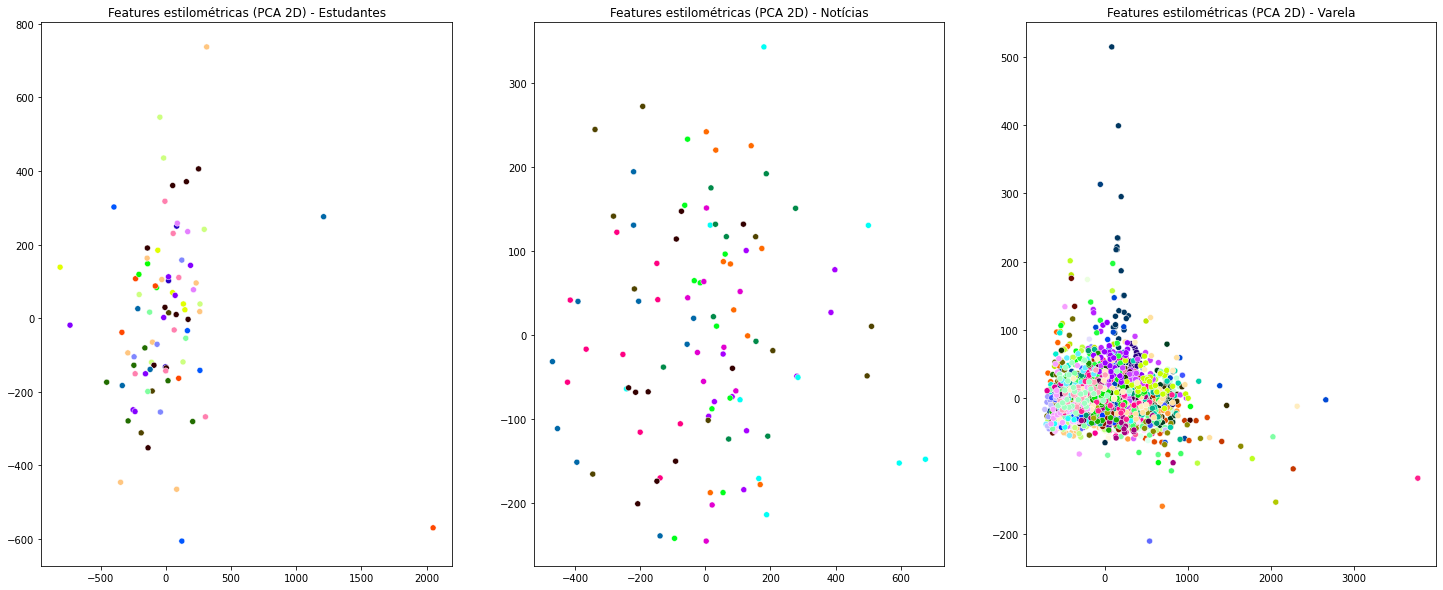

<Figure size 432x288 with 0 Axes>

In [186]:
# Plot stylometric data on PCA-2D and Scaled features

# Feature reduction PCA d=3 and Scaled features

def build_pca_components(dataframe, size):
  pca = PCA(n_components=size, random_state=0)
  pca_result = pca.fit_transform(dataframe)
  dataframe['PCA-one'] = pca_result[:,0]
  dataframe['PCA-two'] = pca_result[:,1] 
  dataframe['PCA-three'] = pca_result[:,2]
  return pca

build_pca_components(news_df, 3)
build_pca_components(df, 3)
build_pca_components(varela_df, 3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all')
fig.set_size_inches(25, 10)

sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue=encoded_Y,
    palette = generate_colormap(16),
    data=df,
    legend=False,
    ax=ax1
)

sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue=encoded_Y_news,
    palette = generate_colormap(10),
    data=news_df,
    legend=False,
    ax=ax2
)

sns.scatterplot(
    x="PCA-one", y="PCA-two",
    hue=encoded_varela_Y,
    palette = generate_colormap(100),
    data=varela_df,
    legend=False,
    ax=ax3
)


set_title_and_labels(ax1, 'PCA 2D', 'Estudantes')
set_title_and_labels(ax2, 'PCA 2D', 'Notícias')
set_title_and_labels(ax3, 'PCA 2D', 'Varela')

plt.figure()

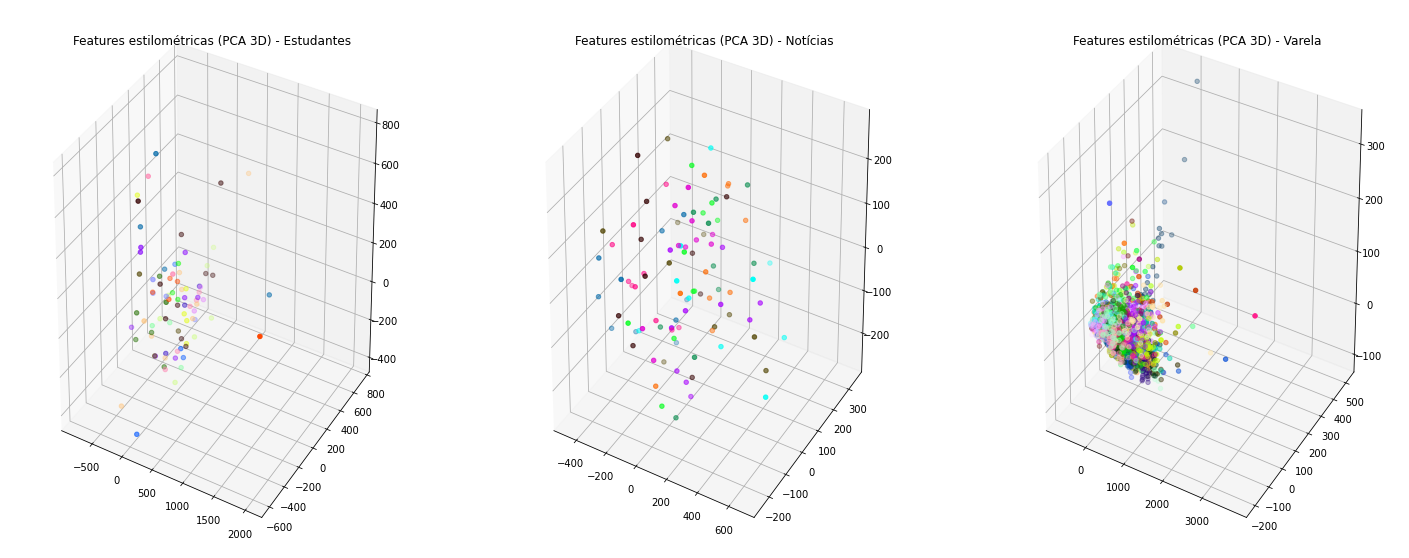

In [187]:
# Plot stylometric data on PCA-3D
fig = plt.figure(figsize=(30,10))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.scatter(
    xs=df.loc[:]["PCA-one"], 
    ys=df.loc[:]["PCA-two"], 
    zs=df.loc[:]["PCA-three"], 
    c=encoded_Y, 
    cmap=generate_colormap(16),
)

ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax1.scatter(
    xs=news_df.loc[:]["PCA-one"], 
    ys=news_df.loc[:]["PCA-two"], 
    zs=news_df.loc[:]["PCA-three"], 
    c=encoded_Y_news, 
    cmap=generate_colormap(10)
)

ax2 = fig.add_subplot(1, 3, 3, projection='3d')
ax2.scatter(
    xs=varela_df.loc[:]["PCA-one"], 
    ys=varela_df.loc[:]["PCA-two"], 
    zs=varela_df.loc[:]["PCA-three"], 
    c=encoded_varela_Y, 
    cmap=generate_colormap(100)
)

set_title_and_labels(ax, 'PCA 3D', 'Estudantes', is_3d=True)
set_title_and_labels(ax1, 'PCA 3D', 'Notícias', is_3d=True)
set_title_and_labels(ax2, 'PCA 3D', 'Varela', is_3d=True)


fig.set_size_inches(25, 10)
plt.show()

In [267]:
# Clear dfs before TSNE
def clear_PCA_columns(dataframes):
  for df in dataframes:
    df.pop('PCA-one')
    df.pop('PCA-two')
    df.pop('PCA-three')

#clear_PCA_columns([df, news_df, varela_df])

# Train model for TNSE reduction and Scaled features

def build_tsne(dataframe, size):
  tsne = TSNE(n_components=size, verbose=1, perplexity=40, random_state=0)
  tsne_results = tsne.fit_transform(dataframe)
  dataframe['TSNE-2d-one'] = tsne_results[:,0]
  dataframe['TSNE-2d-two'] = tsne_results[:,1]
  dataframe['TSNE-2d-three'] = tsne_results[:,2]


build_tsne(df, 3)
build_tsne(news_df, 3)
build_tsne(varela_df, 3)

[t-SNE] Computing 83 nearest neighbors...
[t-SNE] Indexed 84 samples in 0.000s...
[t-SNE] Computed neighbors for 84 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 84 / 84
[t-SNE] Mean sigma: 20.388702
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.893745
[t-SNE] KL divergence after 1000 iterations: 1.248647
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 62.349359
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.589355
[t-SNE] KL divergence after 1000 iterations: 0.900341
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.025s...
[t-SNE] Computed neighbors for 3000 samples in 0.422s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000


<Figure size 432x288 with 0 Axes>

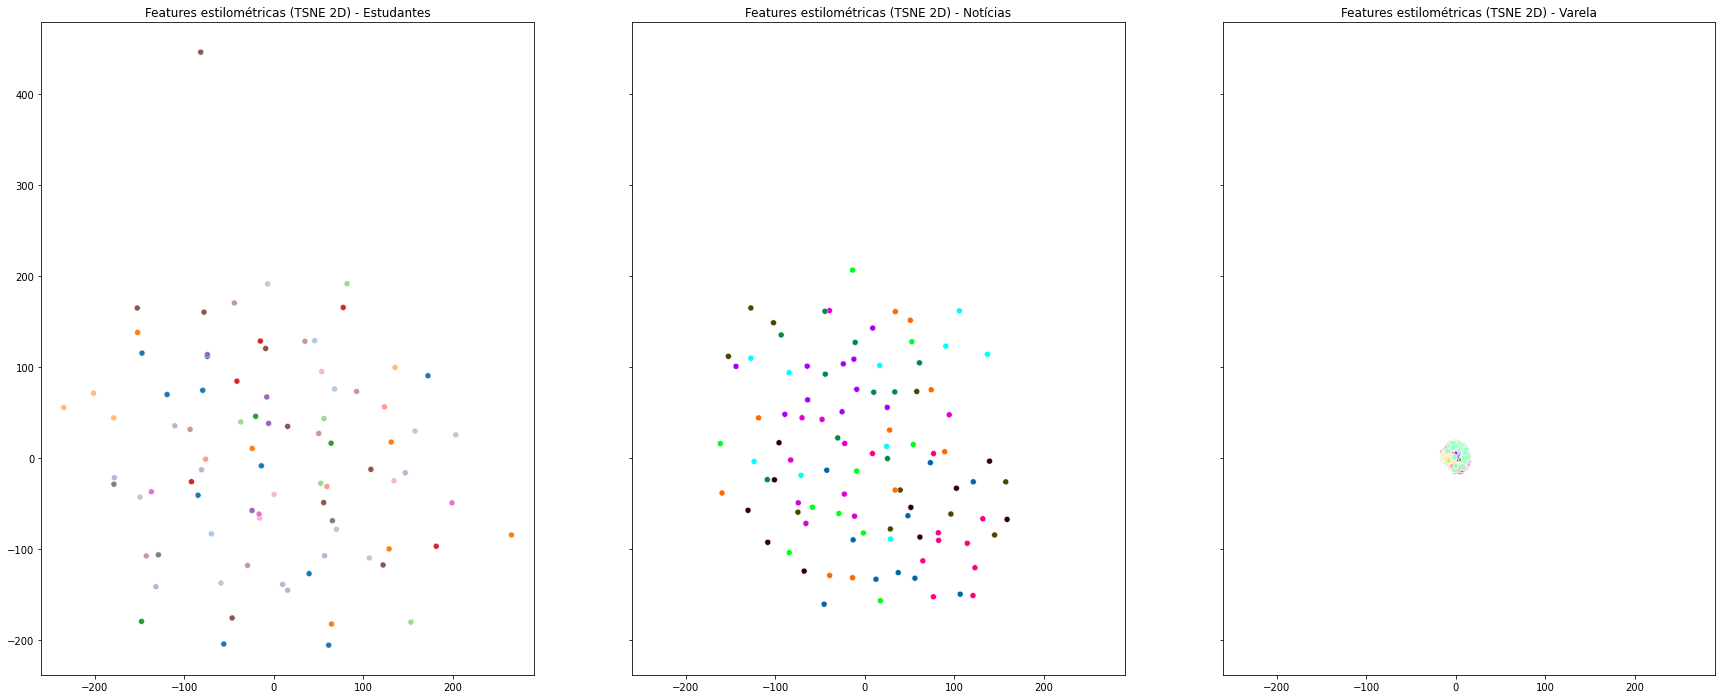

<Figure size 432x288 with 0 Axes>

In [268]:
# Plot stylometric data on TSNE-2D

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='all', sharey='all')
fig.set_size_inches(30, 12)

sns.scatterplot(
    x="TSNE-2d-one", y="TSNE-2d-two",
    hue=encoded_Y,
    palette=sns.color_palette("tab20", 16),
    data=df,
    legend=False,
    ax=ax1
)

sns.scatterplot(
    x="TSNE-2d-one", y="TSNE-2d-two",
    hue=encoded_Y_news,
    palette=generate_colormap(10),
    data=news_df,
    legend=False,
    ax=ax2
)

sns.scatterplot(
    x="TSNE-2d-one", y="TSNE-2d-two",
    hue=encoded_varela_Y,
    palette=generate_colormap(100),
    data=varela_df,
    legend=False,
    ax=ax3
)


set_title_and_labels(ax1, 'TSNE 2D', 'Estudantes')
set_title_and_labels(ax2, 'TSNE 2D', 'Notícias')
set_title_and_labels(ax3, 'TSNE 2D', 'Varela')


plt.figure()
#TODO : Investigate Varela visualization - looking odd -.-'

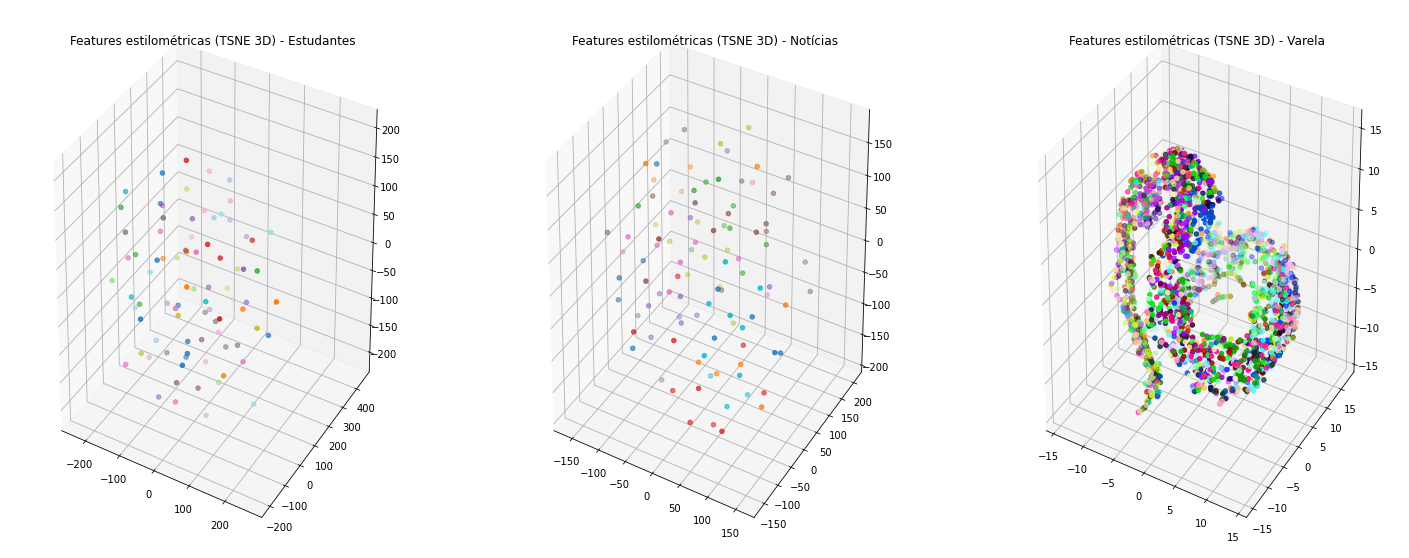

In [272]:
# Plot stylometric data on TSNE-3D 

fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.scatter(
    xs=df.loc[:]["TSNE-2d-one"], 
    ys=df.loc[:]['TSNE-2d-two'], 
    zs=df.loc[:]['TSNE-2d-three'], 
    c=encoded_Y, 
    cmap='tab20',
)

ax1 = fig.add_subplot(1, 3, 2, projection='3d')

ax1.scatter(
    xs=news_df.loc[:]["TSNE-2d-one"], 
    ys=news_df.loc[:]["TSNE-2d-two"], 
    zs=news_df.loc[:]["TSNE-2d-three"], 
    c=encoded_Y_news, 
    cmap='tab10'
)

ax2 = fig.add_subplot(1, 3, 3, projection='3d')

ax2.scatter(
    xs=varela_df.loc[:]["TSNE-2d-one"], 
    ys=varela_df.loc[:]["TSNE-2d-two"], 
    zs=varela_df.loc[:]["TSNE-2d-three"], 
    c=encoded_varela_Y, 
    cmap=generate_colormap(100)
)


set_title_and_labels(ax, 'TSNE 3D', 'Estudantes', is_3d=True)
set_title_and_labels(ax1, 'TSNE 3D', 'Notícias', is_3d=True)
set_title_and_labels(ax2, 'TSNE 3D', 'Varela', is_3d=True)

plt.show()

In [159]:
#Prepare data for TF-IDF visualization
def red_dimen_with_idf(series, n_components=3):
  X_tfidf = TfidfVectorizer().fit_transform(series)
  return TruncatedSVD(n_components=n_components, random_state=42).fit_transform(X_tfidf) 

raw_student_3d  = red_dimen_with_idf(raw_df['Text'])
raw_news_3d  = red_dimen_with_idf(raw_news_df['Text'])
raw_varela_3d  = red_dimen_with_idf(raw_varela_df['Text'])

raw_student_2d = red_dimen_with_idf(raw_df['Text'],n_components=2)
raw_news_2d  = red_dimen_with_idf(raw_news_df['Text'], n_components=2)
raw_varela_2d  = red_dimen_with_idf(raw_varela_df['Text'], n_components=2)

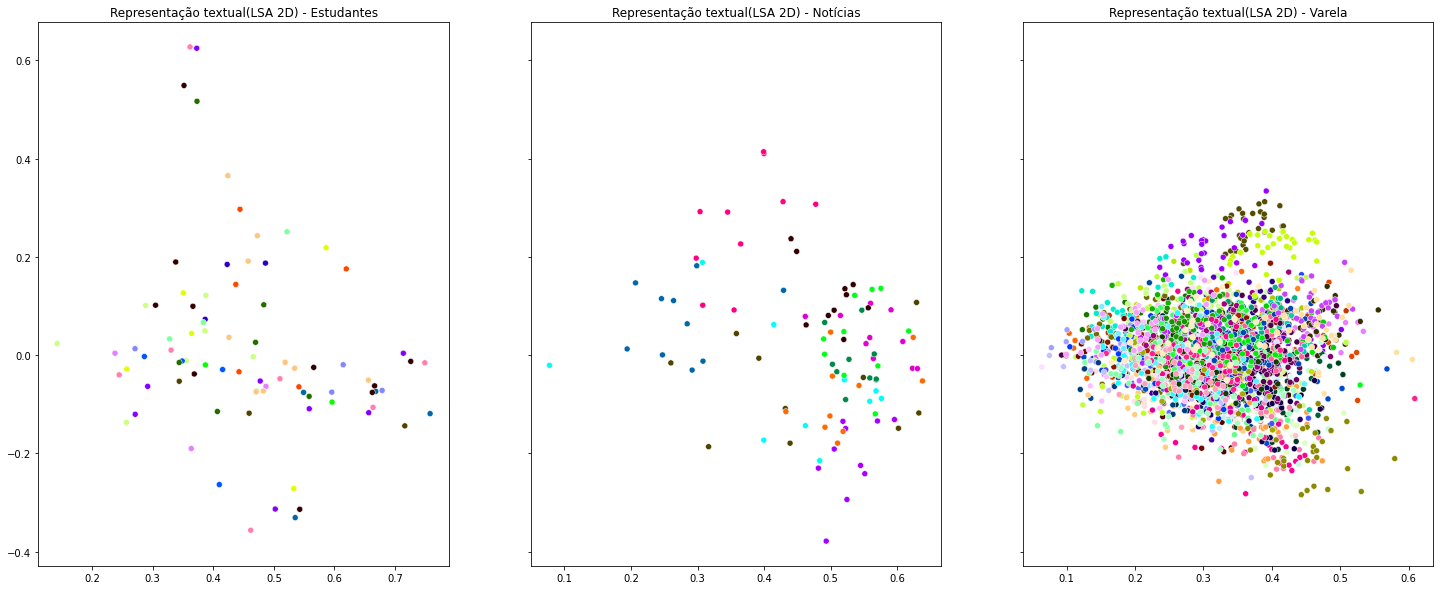

<Figure size 432x288 with 0 Axes>

In [273]:
#TF-IDF LSA 2D

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='all')
fig.set_size_inches(25, 10)

sns.scatterplot(
    x=raw_student_2d[:,0],
    y=raw_student_2d[:,1],
    hue=encoded_raw_Y,
    palette = generate_colormap(16),
    legend=False,
    ax=ax1
)

sns.scatterplot(
    x=raw_news_2d[:,0], 
    y=raw_news_2d[:,1],
    hue=encoded_Y_news,
    palette = generate_colormap(10),
    legend=False,
    ax=ax2
)

sns.scatterplot(
    x=raw_varela_2d[:,0],
    y=raw_varela_2d[:,1],
    hue=encoded_varela_Y,
    palette = generate_colormap(100),
    legend=False,
    ax=ax3
)

plt.figure()

set_title_and_labels(ax1, 'LSA 2D', 'Estudantes', stylo=False)
set_title_and_labels(ax2, 'LSA 2D', 'Notícias' , stylo=False)
set_title_and_labels(ax3, 'LSA 2D', 'Varela' , stylo=False)

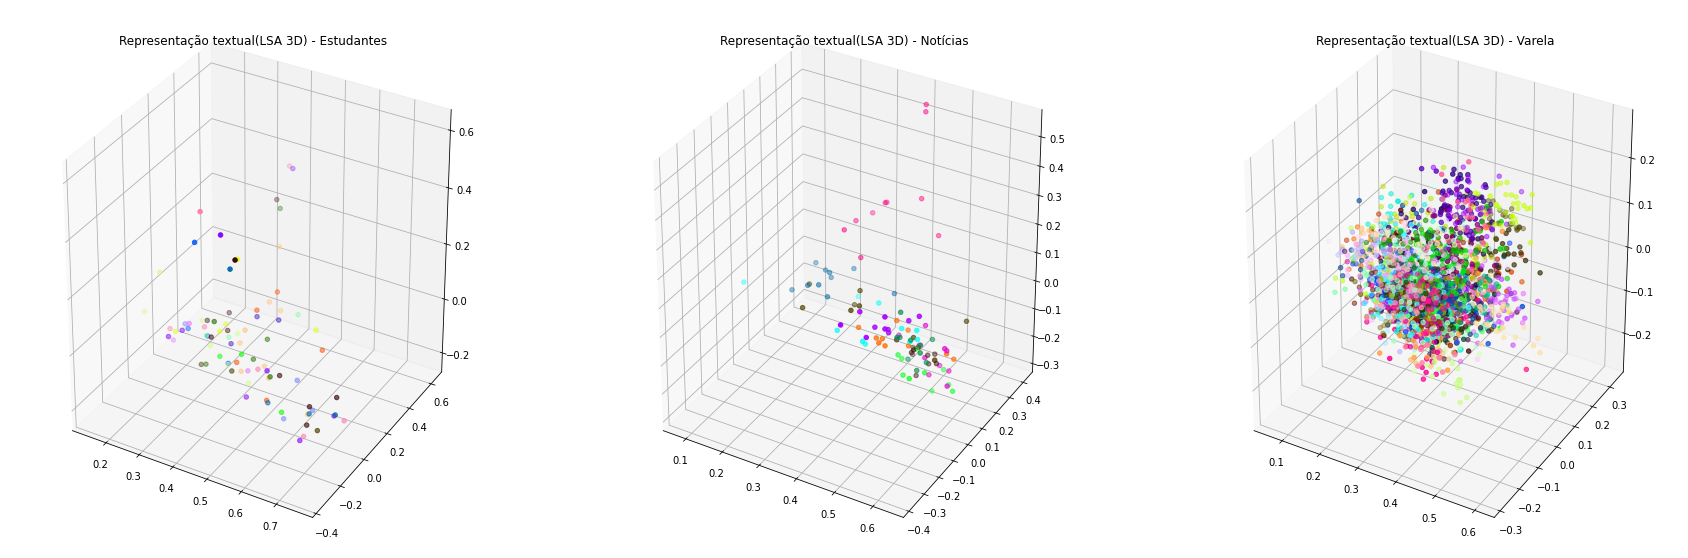

In [182]:
#TF-IDF LSA 3D
def scatter_3d(ax, X, y, size):
  ax.scatter(
      xs=X[:, 0], 
      ys=X[:, 1], 
      zs=X[:, 2], 
      c=y, 
      cmap=generate_colormap(size)  
  )

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax2 = fig.add_subplot(1, 3, 3, projection='3d')

scatter_3d(ax, raw_student_3d, encoded_raw_Y, 16)
scatter_3d(ax1, raw_news_3d, encoded_Y_news, 10)
scatter_3d(ax2, raw_varela_3d, encoded_varela_Y, 100)

set_title_and_labels(ax, 'LSA 3D', 'Estudantes', is_3d=True, stylo=False)
set_title_and_labels(ax1, 'LSA 3D', 'Notícias', is_3d=True, stylo=False)
set_title_and_labels(ax2, 'LSA 3D', 'Varela', is_3d=True, stylo=False)

plt.show()

In [162]:
# Plot word-embedding visualization
# Download gloVe word embedding for portuguese-BR (100-dimensions)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

glove_50_link = 'https://drive.google.com/open?id=10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz'

fluff, id = glove_50_link.split('=')
glove_file_name = 'glove_s50.txt'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(glove_file_name)
glove_file_name

# Load the embedding into a dictionary (eg: {'oi' : n1, n2, ..., n100})
word_embedding_dict = {}
with open(glove_file_name, 'r', encoding='utf-8') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)  
    coefs = np.fromstring(coefs, 'f', sep=' ')
    word_embedding_dict[word] = coefs

In [99]:
corpus = raw_df['Text']
corpus_news = raw_news_df['Text']
corpus_varela = raw_varela_df['Text']

def build_matrix(corpus, dim_size, word_dict):
  tokenizer = Tokenizer(num_words=140000)
  tokenizer.fit_on_texts(corpus)
  # Convert strings to their corresponding integer value created by the Tokenizer
  embedded_sentences = tokenizer.texts_to_sequences(corpus)
  max_words_text = max(corpus, key=lambda sentence: len(nltk.word_tokenize(sentence, language='portuguese')))
  max_sentence_len = len(nltk.word_tokenize(max_words_text, language='portuguese'))
  padded_sentences = pad_sequences(embedded_sentences, max_sentence_len, padding='post')
  vocab_len = len(tokenizer.word_index) + 1

  # Create an embedding matrix, in other words, use the weights from gloVe vector against all our corpus
  # In the end we will have a matrix of all our vocabulary x 50 dimensions (size of glove dim)

  # initialize with all zeros
  embedding_matrix = np.zeros((vocab_len, dim_size))
  for word, index in tokenizer.word_index.items():
    embedding_vector = word_dict.get(word)
    # if the word is in gloVe, we will use its weigths 
    if embedding_vector is not None and embedding_vector.any():
      embedding_matrix[index] = embedding_vector[:dim_size]
  return embedding_matrix, 


# Those matrixes are not necessary for visualization
#student_glove_50 = build_matrix(corpus, 50, word_embedding_dict)
#news_glove_50 = build_matrix(corpus_news, 50, word_embedding_dict)
#varela_glove_50 = build_matrix(corpus_varela, 50, word_embedding_dict)


In [138]:
def convert_docs_to_embeddings(corpus, word_dict, dim_size):
  tokenizer = Tokenizer(num_words=40000)
  tokenizer.fit_on_texts(corpus)
  
  max_words_text = max(corpus, key=lambda sentence: len(nltk.word_tokenize(sentence, language='portuguese')))
  max_sentence_len = len(nltk.word_tokenize(max_words_text, language='portuguese'))
  vocab_len = len(tokenizer.word_index) + 1

  docs = np.zeros((len(corpus), vocab_len, dim_size))
  
  for index, doc in enumerate(corpus):
    current_doc = np.zeros((vocab_len, dim_size))
    # NOTE: I realized that nltk.word_tokenize has a different behavior than split ''
    for word in doc.split(' '):
      embedding_vector = word_dict.get(word)
      if word.isalnum() and embedding_vector is not None and embedding_vector.any():
        idx = tokenizer.word_index[word]
        current_doc[idx] = embedding_vector[:dim_size]
    docs[index] = current_doc
  return docs
    


student_embedded_docs = convert_docs_to_embeddings(corpus, word_embedding_dict, 50)
#news_embedded_docs = convert_docs_to_embeddings(corpus_news, word_embedding_dict, 50)

# Crashing out of RAM
#varela_embedded_docs = convert_docs_to_embeddings(corpus_varela_sw, word_embedding_dict, 50)

In [ ]:
# cleaning up stopwords from Varela to see if memory can handle now
corpus_varela.shape

corpus_varela_sw = corpus_varela.apply(lambda x: [str(item) for item in x.split(' ') if item not in stopwords])
corpus_varela_sw = corpus_varela_sw.apply(lambda x: ' '.join(x))
corpus_varela_sw

In [163]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize


def build_doc2vec(corpus, vec_size, epochs=100):
  tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(corpus)]
  
  max_epochs = 100
  alpha = 0.025

  model = Doc2Vec(size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)

  model.build_vocab(tagged_data)

  print('start training Doc2Vec')
  for epoch in range(max_epochs):
    model.train(tagged_data,total_examples=model.corpus_count,epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

  
  return model


student_d2vec_model = build_doc2vec(corpus, 100)
news_d2vec_model = build_doc2vec(corpus_news, 100)
varela_d2vec_model = build_doc2vec(corpus_varela, 100)

start training Doc2Vec
start training Doc2Vec
start training Doc2Vec


In [164]:
student_doc2vec = TSNE(n_components=2, verbose=1, perplexity=40, random_state=0, n_iter=400).fit_transform(student_d2vec_model.docvecs.vectors_docs)
news_doc2vec = TSNE(n_components=2, verbose=1, perplexity=40, random_state=0, n_iter=400).fit_transform(news_d2vec_model.docvecs.vectors_docs)
varela_doc2vec = TSNE(n_components=2, verbose=1, perplexity=40, random_state=0, n_iter=400).fit_transform(varela_d2vec_model.docvecs.vectors_docs)

[t-SNE] Computing 83 nearest neighbors...
[t-SNE] Indexed 84 samples in 0.000s...
[t-SNE] Computed neighbors for 84 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 84 / 84
[t-SNE] Mean sigma: 13.084766
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.639603
[t-SNE] KL divergence after 400 iterations: 1.153075
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 11.764468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.197708
[t-SNE] KL divergence after 400 iterations: 1.272153
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.033s...
[t-SNE] Computed neighbors for 3000 samples in 2.196s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t

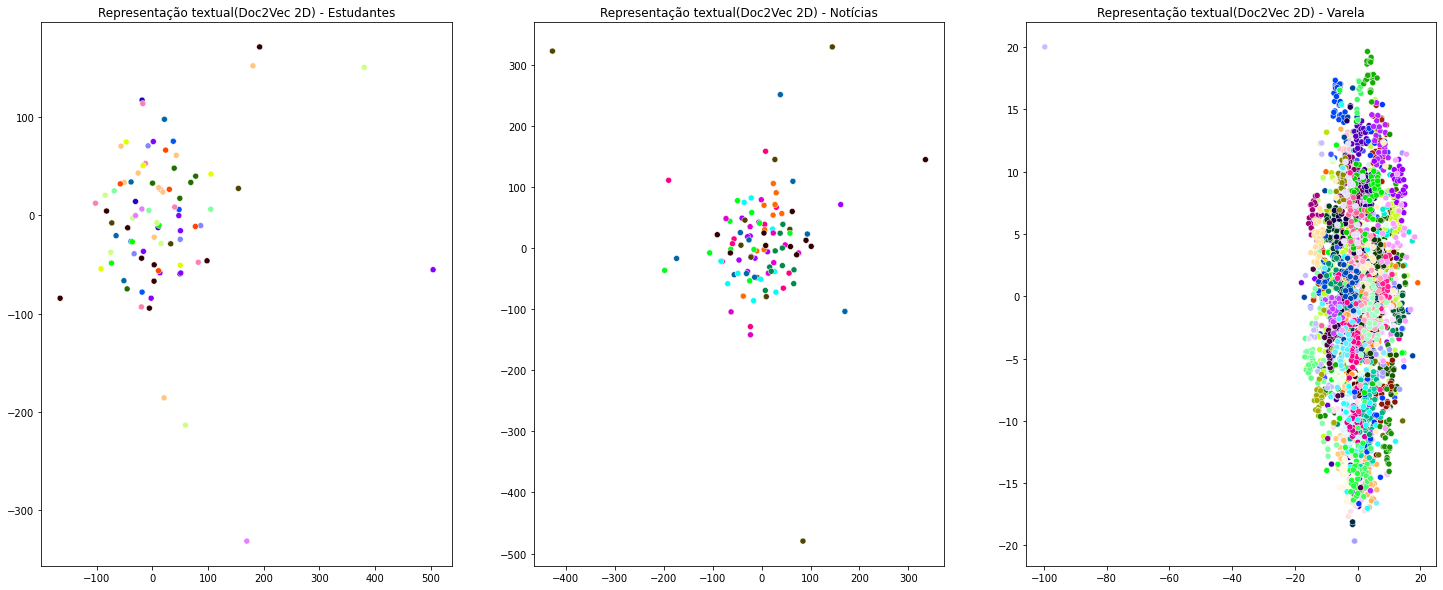

<Figure size 432x288 with 0 Axes>

In [274]:
#Doc2Vec TSNE 2D
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(25, 10)

sns.scatterplot(
    x=student_doc2vec[:,0],
    y=student_doc2vec[:,1],
    hue=encoded_raw_Y,
    palette = generate_colormap(16),
    legend=False,
    ax=ax1
)


sns.scatterplot(
    x=news_doc2vec[:,0], 
    y=news_doc2vec[:,1],
    hue=encoded_Y_news,
    palette = generate_colormap(10),
    legend=False,
    ax=ax2
)

sns.scatterplot(
    x=varela_doc2vec[:,0],
    y=varela_doc2vec[:,1],
    hue=encoded_varela_Y,
    palette = generate_colormap(100),
    legend=False,
    ax=ax3
)

plt.figure()

set_title_and_labels(ax1, 'Doc2Vec 2D', 'Estudantes',stylo=False)
set_title_and_labels(ax2, 'Doc2Vec 2D', 'Notícias',stylo=False )
set_title_and_labels(ax3, 'Doc2Vec 2D', 'Varela',stylo=False)

In [ ]:
student_doc2vec = TSNE(n_components=3, verbose=1, perplexity=40, random_state=0, n_iter=400).fit_transform(student_d2vec_model.docvecs.vectors_docs)
news_doc2vec = TSNE(n_components=3, verbose=1, perplexity=40, random_state=0, n_iter=400).fit_transform(news_d2vec_model.docvecs.vectors_docs)
varela_doc2vec = TSNE(n_components=3, verbose=1, perplexity=40, random_state=0, n_iter=400).fit_transform(varela_d2vec_model.docvecs.vectors_docs)


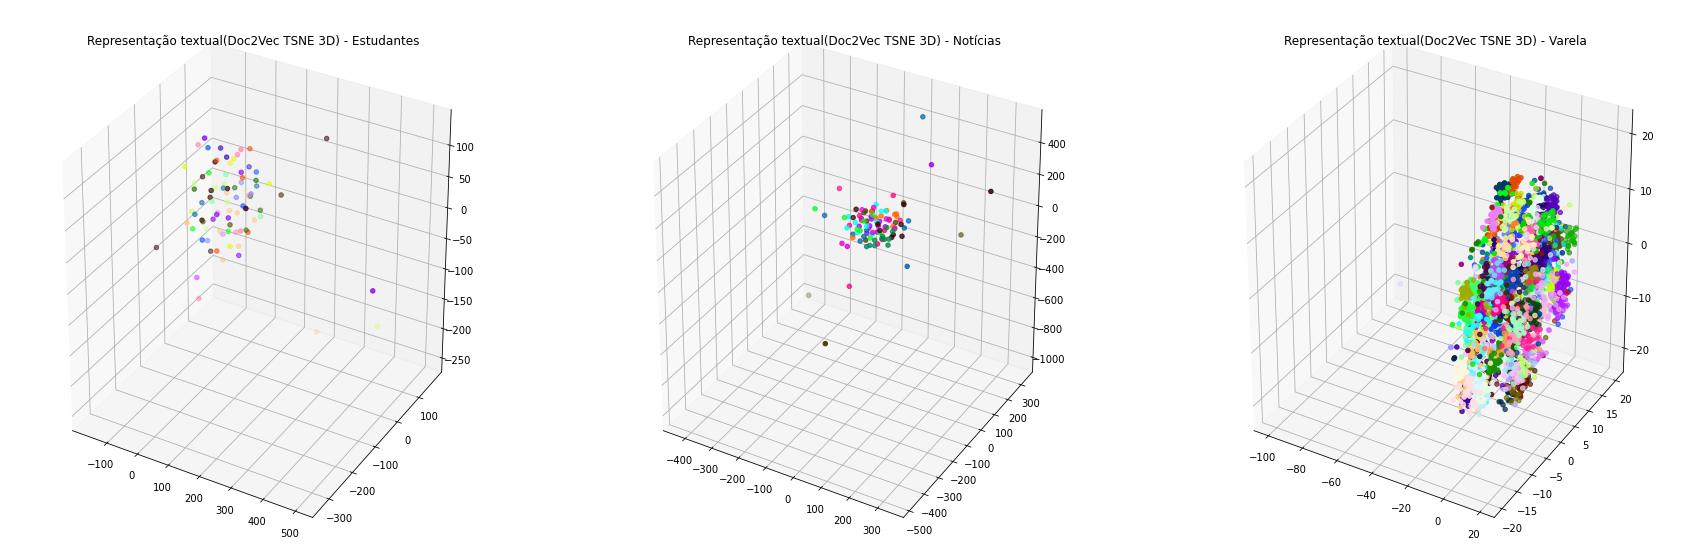

In [275]:
#Doc2Vec TSNE 3D

fig = plt.figure(figsize=(30,10))
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax1 = fig.add_subplot(1, 3, 2, projection='3d')
ax2 = fig.add_subplot(1, 3, 3, projection='3d')

scatter_3d(ax, student_doc2vec, encoded_raw_Y, 16)
scatter_3d(ax1, news_doc2vec, encoded_Y_news, 10)
scatter_3d(ax2, varela_doc2vec, encoded_varela_Y, 100)


set_title_and_labels(ax, 'Doc2Vec TSNE 3D', 'Estudantes', is_3d=True, stylo=False)
set_title_and_labels(ax1, 'Doc2Vec TSNE 3D', 'Notícias', is_3d=True, stylo=False)
set_title_and_labels(ax2, 'Doc2Vec TSNE 3D', 'Varela', is_3d=True, stylo=False)

plt.show()

In [174]:
student_doc2vec.shape

(84, 2)

In [ ]:
# Train model for TNSE reduction and Scaled features

def build_tsne_for_embeddings(embedded, size):
  return TSNE(n_components=size, verbose=1, perplexity=40, random_state=0, n_iter=400).fit_transform(embedded)

student_glove_tsne = build_tsne_for_embeddings(student_glove_50, 3)
#build_tsne(news_df, 3)
#build_tsne(varela_df, 3)



In [263]:
#raw_df_test

vectorizer = TfidfVectorizer()
Z = vectorizer.fit_transform(raw_df['Text'])
print(X_tfidf.shape)
#print(vectorizer.get_feature_names())


tokenizer = Tokenizer(num_words=140000)
tokenizer.fit_on_texts(raw_df['Text'])
print(len(tokenizer.word_index))


#raw_df['Text'].str.split(' ')
res = raw_df['Text'].apply(nltk.word_tokenize(language='portuguese'))
res

(84, 5392)
5526


TypeError: ignored